# UK Web Archive Holdings Summary Report

__WARNING!__ This takes a little while to work...

n.b. There is an SQL interface for Solr, but it's not quite powerful enough to do all we need (in particular, grouping by date ranges so we can do financial year reporting). This report depends on pre-generated TrackDB and AWS item data files.

## Contents

* [Overall Statistics](#overall)
* [Statistic by Year](#by-year)
* [Statistics by Financial Year](#by-fy)

## Overall Statistics <a class="anchor" id="overall"></a>

First we load the data and look for duplicate data across the different storage services.

In [12]:
import os
import requests
import pandas as pd
from trackdb.humanbytes import HumanBytes
from IPython.display import display, HTML, FileLink, FileLinks

pd.set_option('display.max_rows', 100)

# Pick up source locations:
trackdb_jsonl = os.environ.get('TRACKDB_LIST_JSONL','trackdb_list.jsonl')
aws_jsonl = os.environ.get('AWS_S3_LIST_JSONL','aws_s3_list.jsonl')

# Load TrackDB records:
df = pd.read_json(trackdb_jsonl, lines=True)

# Also load AWS records:
aws_df = pd.read_json(aws_jsonl, lines=True)
# Filter out non-content files:
aws_df  = aws_df[aws_df['kind_s'] != 'unknown']
df = pd.concat([df,aws_df], sort=True)

# Set up timestamp:
df['timestamp_dt']= pd.to_datetime(df['timestamp_dt'])
total_records = len(df)

# Force integers:
df['file_size_l'] = df['file_size_l'].fillna(0)
df['file_size_l'] = df['file_size_l'].apply(int)

display(HTML(f"Found a total of {total_records:,} WARC and crawl log files."))

In [13]:
# Dataframe of all unique paths (drop others for paths appearing in more than one 'fresh' TrackDB record):
dfu = df.drop_duplicates(subset=['file_path_s']).drop(columns=['file_path_s'])

unique_records = len(dfu)

display(HTML(f"Found {unique_records:,} unique files (based on file path). This means there are {(total_records-unique_records):,} files duplicated across storage systems."))

The following table shows the most recent WARCs for each data store, along with the associated timestamp. This can be used to check the source data for this report is up to date.

In [48]:
pd.set_option('display.max_colwidth', -1)
# Now we look for the most recent WARC files:
dflw = df.filter(items=['hdfs_service_id_s', 'file_path_s', 'kind_s', 'timestamp_dt'], axis=1)
dflw = dflw.loc[dflw['kind_s'] == 'warcs'].sort_values(['timestamp_dt'],ascending=False).groupby('hdfs_service_id_s').first()
dflw = dflw.reset_index().rename(columns={
    'hdfs_service_id_s': 'store',
})
dflw

,store,file_path_s,kind_s,timestamp_dt
0,aws_s3,/heritrix/output/dc2022/20221129124044/warcs/BL-NPLD-20221231213839902-107742-105~npld-dc-heritrix3-worker-1~8443.warc.gz,warcs,2022-12-31 21:38:39.902000+00:00
1,h020,/heritrix/output/frequent-npld/20211105125651/warcs/BL-NPLD-WEBRENDER-frequent-npld-20211105125651-20211219233713621-25721-uvbemtd1.warc.gz,warcs,2021-12-19 23:37:13.621000+00:00
2,h3,/heritrix/output/frequent-npld/20221216004208/warcs/BL-NPLD-WEBRENDER-frequent-npld-20221216004208-20230124065416678-07533-16qo5sjg.warc.gz,warcs,2023-01-24 06:54:16.678000+00:00


## Statistics by Year <a class="anchor" id="by-year"></a>

This table summarises our overall totals for the different kinds of data we hold.

### Overall totals by year

In [14]:
from IPython.display import display

def show_table_and_dl(df, slug):
    # Shift to standard Column Names
    df = df.rename(columns={
        'timestamp_dt': 'year',
        'collection_s': 'collection',
        'stream_s': 'stream',
        'kind_s': 'kind',
        'size': 'size_bytes',
        'count': 'file_count',
        'hdfs_service_id_s': 'store'
    })

    # Add a Total:
    df.loc['Total']= df.sum(numeric_only=True)
    
    # Replace NaNs
    df = df.fillna('')

    # Clean up size formatting:
    df['size'] = df['size_bytes'].apply(lambda x: HumanBytes.format(x, True))
    df['size_bytes'] = df['size_bytes'].apply(int)
    df['file_count'] = df['file_count'].apply(int)
    
    # Also make the data available for download:
    csv_file = f'{slug}.csv'
    df.to_csv(csv_file, index=False)
    dl = FileLink(csv_file, result_html_prefix='Download the data from this table here: ')
    display(df,dl)

#tots = dfu.groupby([pd.Grouper(key='timestamp_dt', freq="A"), 'collection_s', 'stream_s', 'hdfs_service_id_s', 'kind_s']).agg(count=('file_size_l', 'count'), size=('file_size_l', 'sum'))
tots = dfu.groupby([pd.Grouper(key='timestamp_dt', freq="A")]).agg(count=('file_size_l', 'count'), size=('file_size_l', 'sum'))
tots = tots.reset_index()

# Clip year:
tots['timestamp_dt'] = tots['timestamp_dt'].dt.year.apply(lambda x: str(x))

# Show table and downloader:
show_table_and_dl(tots, 'totals_by_year')


,year,file_count,size_bytes,size
0,2010,5128,889707367400,889.7 GB
1,2011,152823,9752750101708,9.8 TB
2,2012,62693,5155656912300,5.2 TB
3,2013,99566,44626484557524,44.6 TB
4,2014,111345,74965482998137,75.0 TB
5,2015,131242,92377023633565,92.4 TB
6,2016,136996,131955902382200,132.0 TB
7,2017,135265,104515586779827,104.5 TB
8,2018,139734,120955715797493,121.0 TB
9,2019,187203,169359134779426,169.4 TB


/home/anj/ukwa-notebook-apps/totals_by_year.csv

### Totals by Year & Collection

In [15]:
#tots = dfu.groupby([pd.Grouper(key='timestamp_dt', freq="A"), 'collection_s', 'stream_s', 'hdfs_service_id_s', 'kind_s']).agg(count=('file_size_l', 'count'), size=('file_size_l', 'sum'))
tots = dfu.groupby([pd.Grouper(key='timestamp_dt', freq="A"), 'collection_s']).agg(count=('file_size_l', 'count'), size=('file_size_l', 'sum'))
tots = tots.reset_index()

# Clip year:
tots['timestamp_dt'] = tots['timestamp_dt'].dt.year.apply(lambda x: str(x))

# Show table and downloader:
show_table_and_dl(tots, 'totals_by_year_collection')


,year,collection,file_count,size_bytes,size
0,2010,selective,5128,889707367400,889.7 GB
1,2011,selective,152823,9752750101708,9.8 TB
2,2012,selective,62693,5155656912300,5.2 TB
3,2013,npld,39719,39651261733311,39.7 TB
4,2013,selective,59847,4975222824213,5.0 TB
5,2014,npld,77222,71825678300361,71.8 TB
6,2014,selective,34123,3139804697776,3.1 TB
7,2015,npld,93216,90102310863233,90.1 TB
8,2015,selective,38026,2274712770332,2.3 TB
9,2016,npld,130400,131562200904391,131.6 TB


/home/anj/ukwa-notebook-apps/totals_by_year_collection.csv

### Totals by Year, Collection, Stream, Store & Kind

In [16]:
tots = dfu.groupby([pd.Grouper(key='timestamp_dt', freq="A"), 'collection_s', 'stream_s', 'hdfs_service_id_s', 'kind_s']).agg(count=('file_size_l', 'count'), size=('file_size_l', 'sum'))
tots = tots.reset_index()

# Clip year:
tots['timestamp_dt'] = tots['timestamp_dt'].dt.year.apply(lambda x: str(x))

# Show table and downloader:
show_table_and_dl(tots, 'totals_by_year_collection_stream_store_kind')


,year,collection,stream,store,kind,file_count,size_bytes,size
0,2010,selective,selective,h020,crawl-logs,50,16174178,16.2 MB
1,2010,selective,selective,h020,warcs,5078,889691193222,889.7 GB
2,2011,selective,selective,h020,crawl-logs,30896,70177720850,70.2 GB
3,2011,selective,selective,h020,warcs,121927,9682572380858,9.7 TB
4,2012,selective,selective,h020,crawl-logs,11337,29180359746,29.2 GB
5,2012,selective,selective,h020,warcs,51356,5126476552554,5.1 TB
6,2013,npld,domain,h020,crawl-logs,9,497880630017,497.9 GB
7,2013,npld,domain,h020,viral,10,4378472582,4.4 GB
8,2013,npld,domain,h020,warcs,33102,33902836541889,33.9 TB
9,2013,npld,frequent,h020,viral,17,99041071,99.0 MB


/home/anj/ukwa-notebook-apps/totals_by_year_collection_stream_store_kind.csv

## Statistics by Financial Year <a class="anchor" id="by-fy"></a>

The same data, but aggregating by financial year.

### Totals by Financial Year

In [17]:
by_fy = dfu.groupby([pd.Grouper(key='timestamp_dt', freq="A-MAR")]).agg(count=('file_size_l', 'count'), size=('file_size_l', 'sum'))

# Removed heirarchical index so we can plot:
by_fy = by_fy.reset_index()

# Transform how FY is presented:
by_fy['timestamp_dt'] = by_fy['timestamp_dt'].dt.year.apply(lambda x: str(x-1) + "-" + str(x))

# Show table and downloader:
show_table_and_dl(by_fy, 'totals_by_fy')

,year,file_count,size_bytes,size
0,2010-2011,113204,7816892967770,7.8 TB
1,2011-2012,59960,4030906309550,4.0 TB
2,2012-2013,79156,6721789281245,6.7 TB
3,2013-2014,81051,44989409025831,45.0 TB
4,2014-2015,114626,75189816802413,75.2 TB
5,2015-2016,129525,97636439682175,97.6 TB
6,2016-2017,144414,132324447179156,132.3 TB
7,2017-2018,121999,100724574184843,100.7 TB
8,2018-2019,153246,135805661816176,135.8 TB
9,2019-2020,178575,162784476670294,162.8 TB


/home/anj/ukwa-notebook-apps/totals_by_fy.csv

### Totals by Financial Year, Collection, Stream, Store & Kind

In [18]:
by_fy = dfu.groupby([pd.Grouper(key='timestamp_dt', freq="A-MAR"), 'collection_s', 'stream_s', 'hdfs_service_id_s', 'kind_s']).agg(count=('file_size_l', 'count'), size=('file_size_l', 'sum'))

# Removed heirarchical index so we can plot:
by_fy = by_fy.reset_index()

# Transform how FY is presented:
by_fy['timestamp_dt'] = by_fy['timestamp_dt'].dt.year.apply(lambda x: str(x-1) + "-" + str(x))

# Show table and downloader:
show_table_and_dl(by_fy, 'totals_by_fy_collection_stream_store_kind')

,year,collection,stream,store,kind,file_count,size_bytes,size
0,2010-2011,selective,selective,h020,crawl-logs,21427,51254365367,51.3 GB
1,2010-2011,selective,selective,h020,warcs,91777,7765638602403,7.8 TB
2,2011-2012,selective,selective,h020,crawl-logs,11920,24930586396,24.9 GB
3,2011-2012,selective,selective,h020,warcs,48040,4005975723154,4.0 TB
4,2012-2013,selective,selective,h020,crawl-logs,14525,38703889530,38.7 GB
5,2012-2013,selective,selective,h020,warcs,64631,6683085391715,6.7 TB
6,2013-2014,npld,domain,h020,crawl-logs,9,497880630017,497.9 GB
7,2013-2014,npld,domain,h020,viral,10,4378472582,4.4 GB
8,2013-2014,npld,domain,h020,warcs,33102,33902836541889,33.9 TB
9,2013-2014,npld,frequent,h020,viral,23,119909960,119.9 MB


/home/anj/ukwa-notebook-apps/totals_by_fy_collection_stream_store_kind.csv

### Graphs of Totals by Stream & Kind, over Time

In [19]:
import altair as alt

by_fy_s = dfu.groupby([pd.Grouper(key='timestamp_dt', freq="A-MAR"), 'stream_s', 'kind_s']).agg(count=('file_size_l', 'count'), size=('file_size_l', 'sum'))

# Removed heirarchical index so we can plot:
by_fy_s = by_fy_s.reset_index()

# Transform how FY is presented:
by_fy_s['fy'] = by_fy_s['timestamp_dt'].dt.year.apply(lambda x: str(x-1) + "-" + str(x))

# Refactor/renaming:
by_fy_s = by_fy_s.filter(['fy', 'stream_s', 'kind_s', 'count', 'size'])

# Present sizes in a readable way
by_fy_s['readable_size'] = by_fy_s['size'].apply(lambda x: HumanBytes.format(x, True))

# Set up the chart:
selection = alt.selection_multi(fields=['stream_s'], bind='legend')

alt.Chart(by_fy_s).mark_bar().encode(
    x=alt.X('fy', axis = alt.Axis(title = 'Financial year')),
    y=alt.Y('size', axis = alt.Axis(title = 'Total bytes', format='s')),
    color='stream_s',
    row=alt.Row('kind_s', title='Kind'),
    opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
    tooltip=[
        alt.Tooltip('fy', title='Financial year'), 
        alt.Tooltip('stream_s', title='Content stream'), 
        alt.Tooltip('count', title='Number of files'), 
        alt.Tooltip('readable_size', title='Total bytes')
    ]
).properties(
    width=800,height=200
).add_selection(
    selection
).resolve_scale(y='independent')

alt.Chart(...)

## Radial Visualization

This is a work in progress and is not working yet.


In [20]:


#for gn, g in dfu.groupby([pd.Grouper(key='timestamp_dt', freq="A"), 'collection_s', 'stream_s', 'hdfs_service_id_s', 'kind_s']):
dfuu = dfu.filter(['timestamp_dt', 'collection_s', 'stream_s', 'hdfs_service_id_s', 'kind_s', 'file_size_l']).rename(
    columns={
        'file_size_l': 'size_bytes', 
        'kind_s': 'kind', 
        'stream_s': 'stream',
        'count': 'file_count',
        'timestamp_dt': 'year',
        'collection_s': 'collection',
        'hdfs_service_id_s': 'store'
    }
)
dfuu

,year,collection,stream,store,kind,size_bytes
0,2022-01-18 07:23:42.430000+00:00,npld,frequent,h3,warcs,1006968461
1,2022-01-18 07:23:42.429000+00:00,npld,frequent,h3,warcs,1006652852
2,2022-01-18 06:57:18.490000+00:00,npld,frequent,h3,warcs,1010961406
3,2022-01-18 06:25:34.721000+00:00,npld,frequent,h3,warcs,1021385500
4,2022-01-18 06:25:34.719000+00:00,npld,frequent,h3,warcs,1013505131
...,...,...,...,...,...,...
287827,2022-12-31 21:12:08.979000+00:00,npld,domain,aws_s3,warcs,660562655
287828,2022-12-31 21:12:09.008000+00:00,npld,domain,aws_s3,warcs,678496443
287829,2022-12-31 21:12:09.010000+00:00,npld,domain,aws_s3,warcs,619855137
287830,2022-12-31 21:38:39.901000+00:00,npld,domain,aws_s3,warcs,305220706


In [21]:
# Build up items for the tree:
#  {
#    "id": 246,
#    "name": "TreeMapLayout",
#    "parent": 231,
#    "size": 9191
#  },


entries = []
entry_id = 0

entries.append({
    'id': entry_id,
    'name': "total",
    'size': dfuu['size_bytes'].sum(),
    'count': dfuu['size_bytes'].count()
})
parent_id = entry_id
entry_id += 1

for ts, ts_g in dfuu.groupby(pd.Grouper(key='year', freq="A")):
    print(ts.year)
    for col, col_g in ts_g.groupby('collection'):
        print(ts.year, col, col_g['size_bytes'].count(), col_g['size_bytes'].sum())
        for stream, stream_g in col_g.groupby('stream'):
            print(ts.year, col, stream)
            for kind, kind_g in stream_g.groupby('kind'):
                print(ts.year, col, stream, kind)
                for store, store_g in kind_g.groupby('store'):
                    print(ts.year, col, stream, kind, store, store_g['size_bytes'].count(), store_g['size_bytes'].sum())

2010
2010 selective 5128 889707367400
2010 selective selective
2010 selective selective crawl-logs
2010 selective selective crawl-logs h020 50 16174178
2010 selective selective warcs
2010 selective selective warcs h020 5078 889691193222
2011
2011 selective 152823 9752750101708
2011 selective selective
2011 selective selective crawl-logs
2011 selective selective crawl-logs h020 30896 70177720850
2011 selective selective warcs
2011 selective selective warcs h020 121927 9682572380858
2012
2012 selective 62693 5155656912300
2012 selective selective
2012 selective selective crawl-logs
2012 selective selective crawl-logs h020 11337 29180359746
2012 selective selective warcs
2012 selective selective warcs h020 51356 5126476552554
2013
2013 npld 39719 39651261733311
2013 npld domain
2013 npld domain crawl-logs
2013 npld domain crawl-logs h020 9 497880630017
2013 npld domain viral
2013 npld domain viral h020 10 4378472582
2013 npld domain warcs
2013 npld domain warcs h020 33102 33902836541889
2

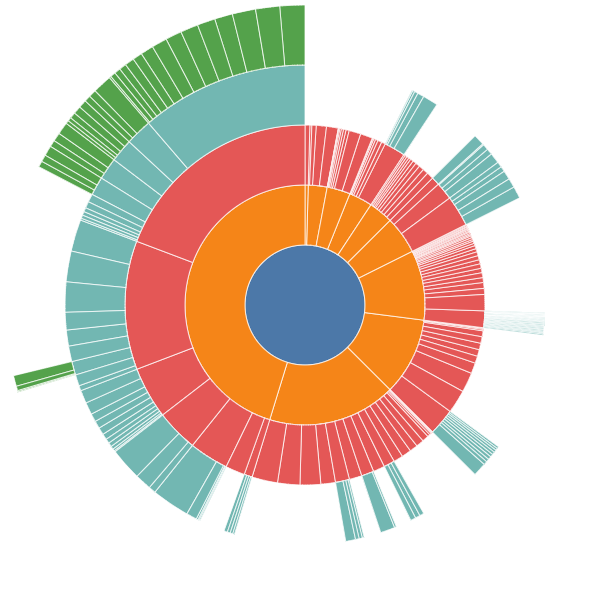

In [22]:
from altair.vega import vega

vega({
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "An example of a space-fulling radial layout for hierarchical data.",
  "width": 600,
  "height": 600,
  "padding": 5,
  "autosize": "none",

  "data": [
    {
      "name": "tree",
      "url": "https://vega.github.io/vega/data/flare.json",
      "transform": [
        {
          "type": "stratify",
          "key": "id",
          "parentKey": "parent"
        },
        {
          "type": "partition",
          "field": "size",
          "sort": {"field": "value"},
          "size": [{"signal": "2 * PI"}, {"signal": "width / 2"}],
          "as": ["a0", "r0", "a1", "r1", "depth", "children"]
        }
      ]
    }
  ],

  "scales": [
    {
      "name": "color",
      "type": "ordinal",
      "domain": {"data": "tree", "field": "depth"},
      "range": {"scheme": "tableau10"}
    }
  ],

  "marks": [
    {
      "type": "arc",
      "from": {"data": "tree"},
      "encode": {
        "enter": {
          "x": {"signal": "width / 2"},
          "y": {"signal": "height / 2"},
          "fill": {"scale": "color", "field": "depth"},
          "tooltip": {"signal": "datum.name + (datum.size ? ', ' + datum.size + ' bytes' : '')"}
        },
        "update": {
          "startAngle": {"field": "a0"},
          "endAngle": {"field": "a1"},
          "innerRadius": {"field": "r0"},
          "outerRadius": {"field": "r1"},
          "stroke": {"value": "white"},
          "strokeWidth": {"value": 0.75},
          "zindex": {"value": 0}
        },
        "hover": {
          "stroke": {"value": "red"},
          "strokeWidth": {"value": 1.5},
          "zindex": {"value": 1}
        }
      }
    }
  ]
})